In [1]:
%run _common.ipynb

Cuda available: True


In [2]:
from src import model_data as md
from matplotlib import pylab as plt
import pandas as pd

In [3]:
pipeline = md.MultiTickerPipeline(
    target="price",
    target_type="single",
    model_seq_len=30,
    max_overlap=20,
    train_periods=[
        ("2012-01-01", "2019-12-31"),
    ],
    test_periods=[
        ("2020-01-01", "2021-04-01"),
    ],
    normalization_method="log",
    cross_validation_folds=5
)

In [4]:
pipeline.load_data('price-single-96tickers')

INFO:src.model_data:Loading generated data from /home/rluo/raid/classes/gatech/cs7643/GATech-CS7643-Project-Group/data/model_data/price-single-96tickers...
INFO:src.model_data:  Loading train folds...
INFO:src.model_data:  Loading test arrays...


In [5]:
train_data = pipeline._train_out
test_data = pipeline._test_out

In [6]:
fold5 = train_data[4]
train = fold5['train']
valid = fold5['valid']

In [7]:
device = "cuda:2"

In [8]:
# x_train, y_train = torch.from_numpy(train['x']).to(device), torch.from_numpy(train['y']).to(device)
x_valid, y_valid = torch.from_numpy(valid['x'].astype("float32")).to(device), torch.from_numpy(valid['y'].astype("float32")).to(device)
x_test, y_test = torch.from_numpy(test_data['x'].astype("float32")).to(device), torch.from_numpy(test_data['y'].astype("float32")).to(device)

In [9]:
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, datadict):
        self.x = datadict['x'].astype("float32")
        self.y = datadict['y'].astype("float32")
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [10]:
class SeqModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        #
        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.lstm(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [11]:
input_dim = x_valid.shape[2]
output_dim = y_valid.shape[1]

In [12]:
hidden_dim = 128
num_layers = 2
num_epochs = 400
learning_rate = 0.001

In [13]:
data_loader_params = {
    "batch_size": 64,
    "shuffle": True,
    "num_workers": 10
}

In [14]:
train_set = SeqDataset(train)

In [15]:
train_loader = torch.utils.data.DataLoader(train_set, **data_loader_params)

In [16]:
model = SeqModel(input_dim, hidden_dim, num_layers, output_dim).to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
criterion = nn.L1Loss(reduction='mean')

In [19]:
num_epochs = 400
early_stopping_epochs = 10

In [20]:
train_hist = []
valid_hist = []
min_observed_valid_loss = np.inf

for epoch in range(num_epochs):
    train_loss_per_batch = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        model.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()
        train_loss_per_batch.append(loss.item())
        del x, y
        torch.cuda.empty_cache()
    train_loss_epoch = np.mean(train_loss_per_batch)
    
    with torch.no_grad():
        y_valid_pred = model(x_valid)
        valid_loss_epoch = criterion(y_valid_pred, y_valid)
        del y_valid_pred
        torch.cuda.empty_cache()

    min_observed_valid_loss = min(min_observed_valid_loss, valid_loss_epoch)
    
    train_hist.append(train_loss_epoch)
    valid_hist.append(valid_loss_epoch)
    
    print(f"Epoch {epoch}, train loss: {train_loss_epoch:.2f}, validation loss: {valid_loss_epoch:.2f}")
    
    if epoch > early_stopping_epochs:
        if min_observed_valid_loss < min(valid_hist[-10:]):
            print(f"Validation loss not improved in the last {early_stopping_epochs} epochs, breaking...")
            break

y_test_pred = model(x_test)
test_loss = criterion(y_test_pred, y_test)
print(f"test loss: {test_loss:.2f}")

Epoch 0, train loss: 80.01, validation loss: 144.41
Epoch 1, train loss: 64.54, validation loss: 126.50
Epoch 2, train loss: 52.35, validation loss: 113.25
Epoch 3, train loss: 46.61, validation loss: 104.73
Epoch 4, train loss: 42.84, validation loss: 98.28
Epoch 5, train loss: 40.12, validation loss: 93.18
Epoch 6, train loss: 38.01, validation loss: 88.60
Epoch 7, train loss: 36.73, validation loss: 84.66
Epoch 8, train loss: 34.90, validation loss: 81.73
Epoch 9, train loss: 33.25, validation loss: 78.54
Epoch 10, train loss: 32.47, validation loss: 75.86
Epoch 11, train loss: 31.19, validation loss: 73.48
Epoch 12, train loss: 30.19, validation loss: 71.26
Epoch 13, train loss: 29.46, validation loss: 69.46
Epoch 14, train loss: 28.82, validation loss: 67.83
Epoch 15, train loss: 28.30, validation loss: 67.02
Epoch 16, train loss: 27.68, validation loss: 65.18
Epoch 17, train loss: 27.13, validation loss: 63.77
Epoch 18, train loss: 26.52, validation loss: 62.50
Epoch 19, train lo

In [1]:
ticker = "AMZN"

In [33]:
ticker_ind = np.argwhere(test_data['ticker'] == ticker).squeeze()

In [34]:
ticker_ypred = y_test_pred.cpu().detach().numpy()[ticker_ind, :]
ticker_y = y_test.cpu().detach().numpy()[ticker_ind, :]
ticker_dates = test_data['prediction_date'][ticker_ind]

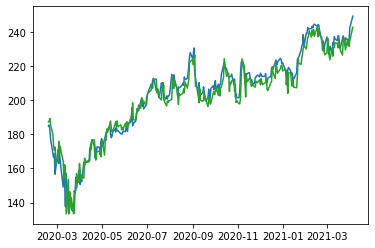

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pd.to_datetime(ticker_dates), ticker_y)
ax.plot(pd.to_datetime(ticker_dates), ticker_ypred, color="C2")

In [36]:
criterion(y_test_pred[ticker_ind, :], y_test[ticker_ind, :])

tensor(4.5884, device='cuda:2', grad_fn=<L1LossBackward>)

In [95]:
x.shape

torch.Size([64, 30, 53])

In [96]:
y.shape

torch.Size([64, 30, 1])

In [94]:
model(x.to(device)).shape

torch.Size([64, 30, 1])